<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.70' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap
import jax_cosmo as jc
from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
# from jaxpm.pm import linear_field, make_ode_fn
from jaxpm.pm import linear_field
from montecosmo.bricks import lpt as mylpt, Planck18, make_ode_fn
from montecosmo.models import get_pk_fn
from montecosmo.utils import theme_switch

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("FastPM")

feynmangpu04.cluster.local
gpu


2024-11-27 23:42:49.233937: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Experiment: artifact_location='mlflow-artifacts:/787048382169915665', creation_time=1732544119620, experiment_id='787048382169915665', last_update_time=1732544119620, lifecycle_stage='active', name='FastPM', tags={}>

# FastPM

In [2]:
from montecosmo.plot import plot_mesh, anim_scan, anim_meshes, plot_pk, plot_pktranscoh, plot_trans, plot_coh
from montecosmo.bricks import linear_pk_interp
from jax_cosmo import Cosmology, background

Planck18 = partial(Cosmology,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,)

box_shape = np.array([1,1,1]) * 640
mesh_shape = np.array([1,1,1]) * 64
a_obs = 1.

In [3]:
from montecosmo.metrics import pktranscoh, power_spectrum
ks, pk0, pk1, trans, coh = pktranscoh(jnp.zeros(mesh_shape), jnp.zeros(mesh_shape), box_shape)
pk_lin = linear_pk_interp(Planck18(), a=a_obs)(ks)

def plot_all(meshes, lpt_order, pm):
    jfn = jit(lambda x: pktranscoh(compensate_cic(meshes[0]), compensate_cic(x), box_shape))
    plt.figure(figsize=(13, 4))
    for go in [0,1]:
        for lo in [0,1]:
            print(f"jpm g{go}-l{lo}")
            ks, pk0, pk1, trans, coh = jfn(meshes[1+lo+2*go])
            print(ks.shape)
            plot_pktranscoh(ks, pk1, trans, coh, label=f"jpm g{go}-l{lo}")

    plt.subplot(131)
    plot_pk(ks, pk0, linestyle='--', color='k', label="fpm")
    plot_pk(ks, pk_lin, linestyle=':', color='k', label="linear")

    plt.legend()
    title = f"zobs={1/a_obs-1:.1f}, lpt order {lpt_order}, pm {pm}, {mesh_shape[0]}"
    plt.suptitle(title)
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), title+".svg")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

CONFIG lpt_order=2, pm=0, a_lpt=1.0, a_obs=1.0
jpm g0-l0
(14,)
jpm g0-l1
(14,)
jpm g1-l0
(14,)
jpm g1-l1
(14,)


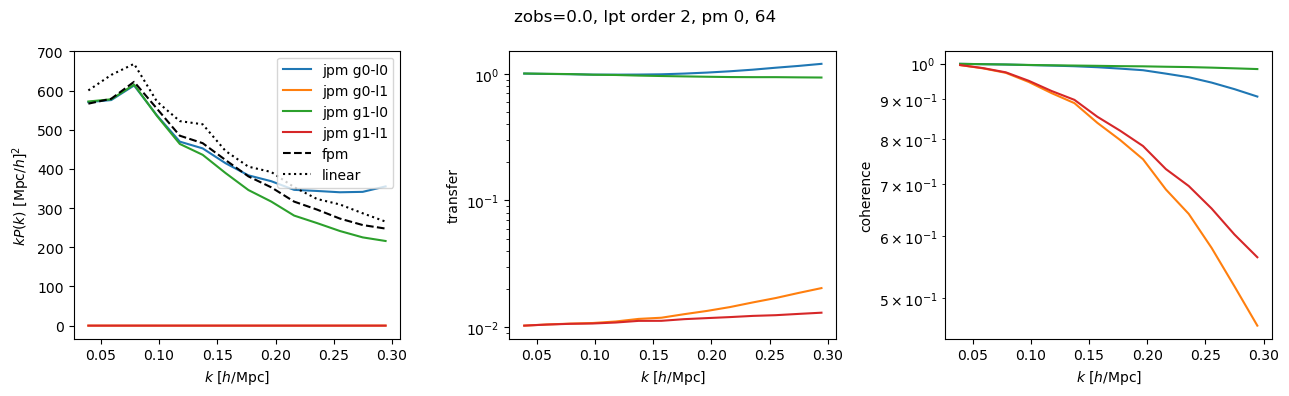

In [8]:
for lpt_order in [2]:
    for pm in [0]:
        if pm==0:
            a_lpt = a_obs
        else:
            a_lpt = 0.1
        print(f"CONFIG {lpt_order=}, {pm=}, {a_lpt=}, {a_obs=}")
        meshes = jnp.load(f"meshes_lpt{lpt_order}_pm{pm}_{mesh_shape[0]}_test.npy")
        plot_all(meshes, lpt_order, pm)


CONFIG lpt_order=2, pm=0, a_lpt=1.0, a_obs=1.0


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


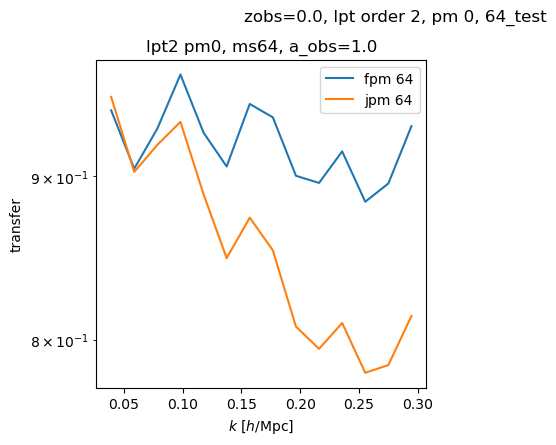

In [7]:
plt.figure(figsize=(8, 8))
for ms in [64]:
    i_plot = 0
    for lpt_order in [2]:
        for pm in [0]:
            if pm==0:
                a_lpt = a_obs
            else:
                a_lpt = 0.1
            print(f"CONFIG {lpt_order=}, {pm=}, {a_lpt=}, {a_obs=}")
            i_plot += 1
            plt.subplot(2,2,i_plot)
            meshes = jnp.load(f"meshes_lpt{lpt_order}_pm{pm}_{ms}_test.npy")

            ks, pk0 = power_spectrum(compensate_cic(meshes[0]), box_shape=box_shape)
            pk_lin = linear_pk_interp(Planck18(), a=a_obs)(ks)
            # plot_pk(ks, pk_lin, linestyle='--', color='k', label=f"linear")

            plot_trans(ks, pk0/pk_lin, linestyle='-',label=f"fpm {ms}")
            # plot_pk(ks, pk0, linestyle='-', label=f"fpm {ms}")

            ks, pk1 = power_spectrum(compensate_cic(meshes[3]), box_shape=box_shape)
            plot_trans(ks, pk1/pk_lin, linestyle='-', label=f"jpm {ms}")
            # plot_pk(ks, pk1, linestyle='-', label=f"jpm {ms}")

            plt.title(f"lpt{lpt_order} pm{pm}, ms{mesh_shape[0]}, {a_obs=}")
            
            plt.legend()
            plt.xlim(*plt.xlim())
title = f"zobs={1/a_obs-1:.1f}, lpt order {lpt_order}, pm {pm}, {mesh_shape[0]}_test"
plt.suptitle(title)
plt.tight_layout()
mlflow.log_figure(plt.gcf(), title+"_ratio.svg")

CONFIG lpt_order=1, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=1, pm=1, a_lpt=0.1, a_obs=0.5
CONFIG lpt_order=2, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=2, pm=1, a_lpt=0.1, a_obs=0.5
CONFIG lpt_order=1, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=1, pm=1, a_lpt=0.1, a_obs=0.5
CONFIG lpt_order=2, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=2, pm=1, a_lpt=0.1, a_obs=0.5
CONFIG lpt_order=1, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=1, pm=1, a_lpt=0.1, a_obs=0.5
CONFIG lpt_order=2, pm=0, a_lpt=0.5, a_obs=0.5
CONFIG lpt_order=2, pm=1, a_lpt=0.1, a_obs=0.5


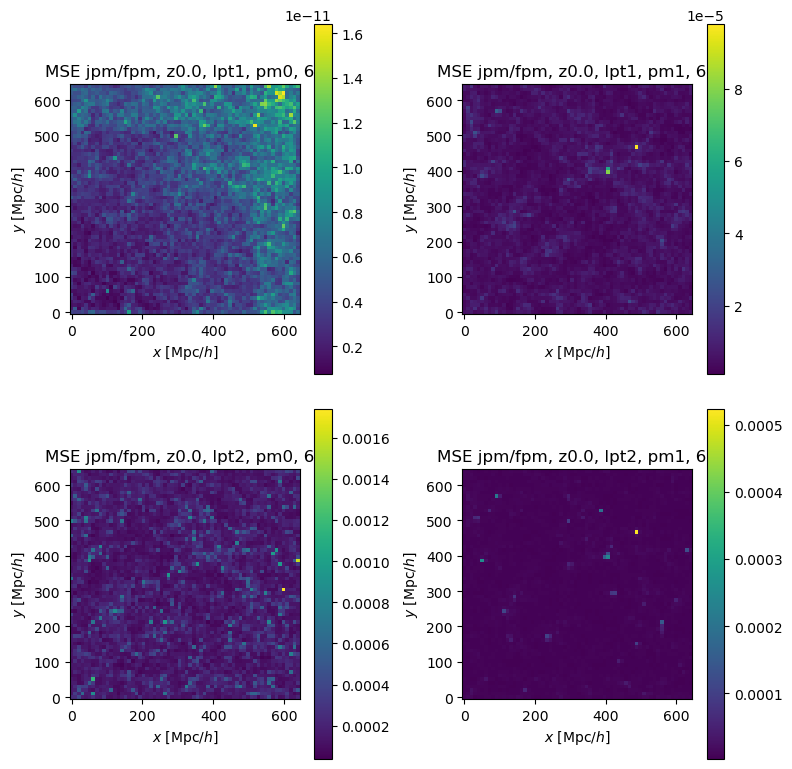

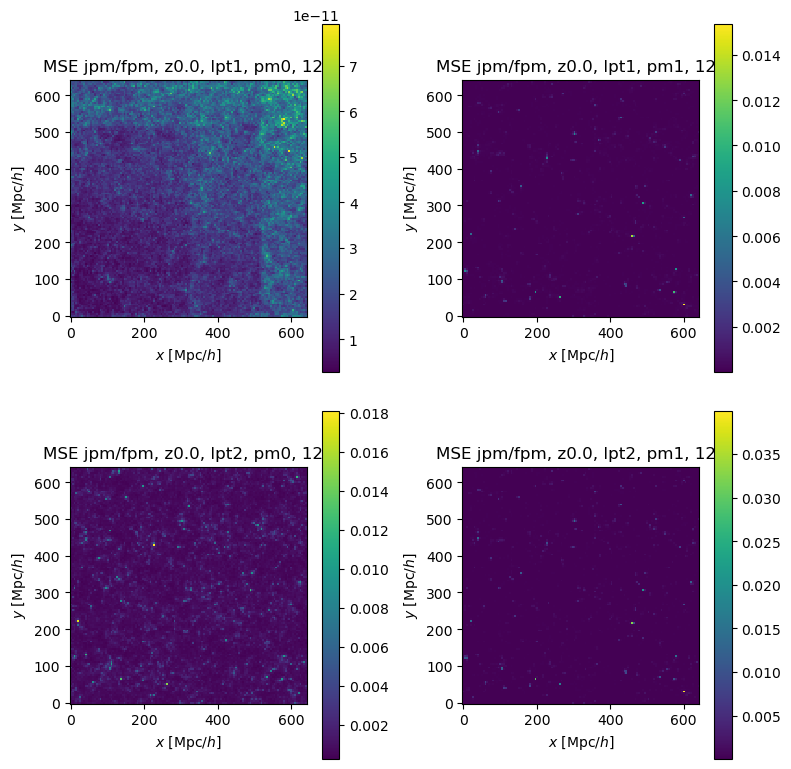

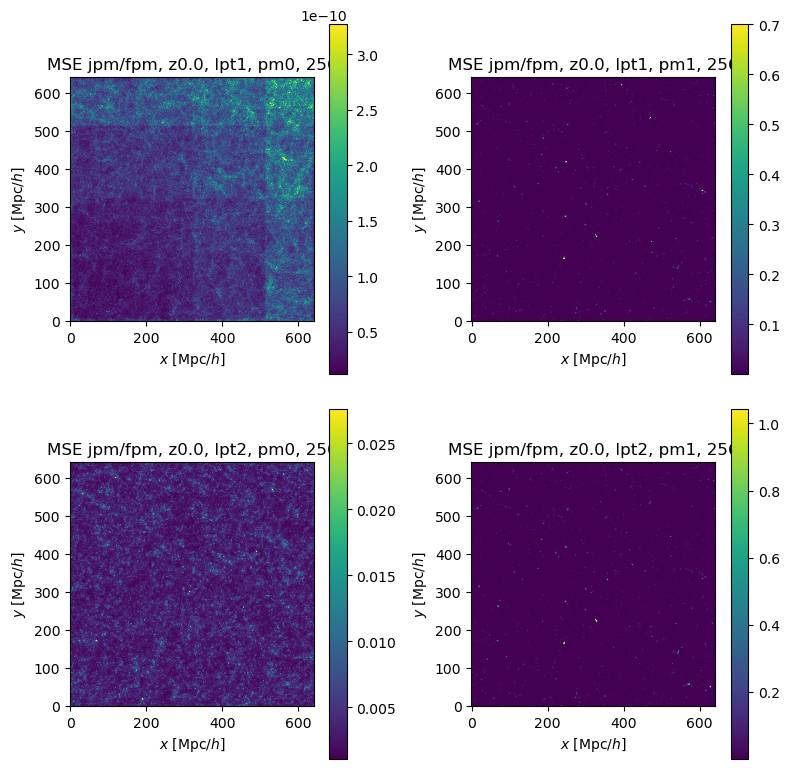

In [ ]:
for ms in [64, 128, 256]:
    plt.figure(figsize=(8, 8))
    i_plot = 0
    for lpt_order in [1, 2]:
        for pm in [0, 1]:
            if pm==0:
                a_lpt = a_obs
            else:
                a_lpt = 0.1
            print(f"CONFIG {lpt_order=}, {pm=}, {a_lpt=}, {a_obs=}")
            i_plot += 1
            plt.subplot(2,2,i_plot)
            meshes = jnp.load(f"meshes_lpt{lpt_order}_pm{pm}_{ms}_z1.npy")
            plt.title(f"MSE jpm/fpm, z{1/a_obs-1:.1f}, lpt{lpt_order}, pm{pm}, {ms}")
            plot_mesh(jnp.abs(meshes[0]-meshes[3])**2, box_shape=box_shape)
            plt.colorbar()
    title = f"zobs={1/a_obs-1:.1f}, lpt order {lpt_order}, pm {pm}, {mesh_shape[0]}"
    plt.tight_layout()
    mlflow.log_figure(plt.gcf(), title+"_meshmse.svg")


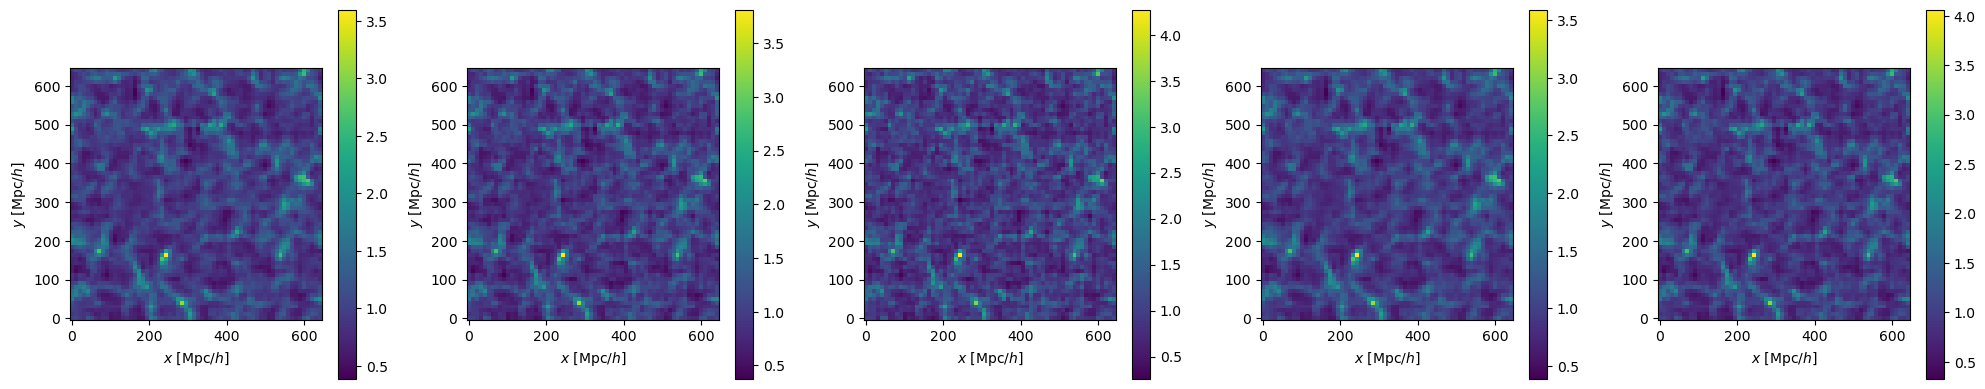

In [9]:
plt.figure(figsize=(20, 4))
for i in range(len(meshes)):
    plt.subplot(1, len(meshes), i+1)
    plot_mesh(meshes[i], box_shape, sli=10)
    plt.colorbar()
plt.tight_layout()

# JaxPM

In [30]:
mesh_length = 256
mesh_shape = mesh_length * np.array([1,1,1])
box_length = 640 # 1600
box_shape  = box_length * np.array([1.,1.,1.])
n_snapshots = 2
a_lpt, a_obs = 0.1, 1.
rsd = False
# grad_order, lap_order = 0, 0

multipoles = [0,2,4]
pk_fn = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles)
# pk_fn = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles)
zeros_mesh = jnp.zeros(mesh_shape)

def run_simulation(cosmology, a_lpt=1., a_obs=1., lpt_order=1, grad_order=1, lap_order=1, rsd=False):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))

    # Initial displacement
    particles = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}  # FIX ME: this a temporary fix
    dx, p, f = mylpt(cosmology, initial_conditions, particles, a_lpt, lpt_order, grad_order, lap_order)
    # return dx, p
    if a_obs == a_lpt:
        pos = particles + dx
    else:
        # Evolve the simulation forward
        snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
        res = odeint(make_ode_fn(mesh_shape, grad_order, lap_order), jnp.stack([particles+dx, p]), snapshots, cosmology, rtol=1e-5, atol=1e-5)
        pos = res[-1,0]
        p = res[-1,1]

    if rsd:        
        dx_rsd = p / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        return cic_paint(zeros_mesh, pos + dx_rsd * jnp.array([0,0,1]))
    else:
        return cic_paint(zeros_mesh, pos)

In [ ]:
cosmology = Planck18()
print(f"Fiducial {cosmology}")
pk_jpm = []
for go in [0,1]:
    for lo in [0,1]:
        pk_lo = []
        for lpto in [1,2]:
            print(f"lpt_order={lpto}, grad_order={go}, lap_order={lo}")
            res = jit(partial(run_simulation, a_lpt=a_obs, a_obs=a_obs, 
                              lpt_order=lpto, grad_order=go, lap_order=lo, rsd=rsd))(cosmology)
            pk_lo.append(pk_fn(compensate_cic(res)))
            res = jit(partial(run_simulation, a_lpt=a_lpt, a_obs=a_obs, 
                              lpt_order=lpto, grad_order=go, lap_order=lo, rsd=rsd))(cosmology)
            pk_lo.append(pk_fn(compensate_cic(res)))
            # del res
        pk_jpm.append(jnp.stack(pk_lo))
pk_jpm = jnp.stack(pk_jpm)

from montecosmo.bricks import linear_pk_interp
pk_lin_obs = jnp.stack([pk_jpm[0,0,0], linear_pk_interp(cosmology, a=a_obs)(pk_jpm[0,0,0])])

# PMWD

In [32]:
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody, lpt
import jax
from jaxpm.growth import growth_factor

ptcl_spacing = box_length / mesh_length # Mpc/h
ptcl_grid_shape = (mesh_length,)*3

def run_pmwd(a_lpt=1., a_obs=1., lpt_order=1, rsd=False):
    jax.config.update("jax_enable_x64", True)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1e-3)
    cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # XXX: sigma8 redshift dependant???
    # cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    cosmo = boltzmann(cosmo, conf)
    # print(cosmo, conf)

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))
    init_modes = jnp.fft.rfftn(initial_conditions)
    init_modes *= growth_factor(cosmology, jnp.atleast_1d(a_lpt)) / growth(a_lpt, cosmo, conf, order=1) * conf.ptcl_cell_vol
    # return lpt(init_modes, cosmo, conf)
    ptcl, obsvbl = lpt(init_modes, cosmo, conf)
    # return ptcl.disp/ptcl_spacing

    # modes = white_noise(0, conf)
    # field = jr.normal(jr.key(0), mesh_shape)
    # modes = jnp.fft.rfftn(field, norm="ortho")
    # modes = linear_modes(modes, cosmo, conf)        
    # ptcl, obsvbl = lpt(modes, cosmo, conf)
    
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    jax.config.update("jax_enable_x64", False)
    # particles = jnp.indices(mesh_shape).reshape(3,-1).T
    # return cic_paint(zeros_mesh, particles + ptcl.disp/ptcl_spacing)
    if rsd:
        dx_rsd = ptcl.vel / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        pos = ptcl.pos() + dx_rsd * jnp.array([0,0,1])
    else:
        pos = ptcl.pos()
    
    # return scatter(ptcl, conf)
    return cic_paint(zeros_mesh, pos/ptcl_spacing)

In [33]:
from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
cosmology = Planck18()
print(f"Fiducial {cosmology}")
# a_lpt, a_obs = 0.1, 1.
a = jnp.atleast_1d(a_obs)
growth_jpm = jnp.concatenate([growth_factor(cosmology, a), 
                              3/7*growth_factor_second(cosmology, a)/ growth_factor(cosmology, a), 
                              growth_factor(cosmology, a)*growth_rate(cosmology, a), 
                              3/7*growth_factor_second(cosmology, a)*growth_rate_second(cosmology, a)/ growth_factor(cosmology, a)]) / growth_factor(cosmology, a)
print("jpm:", growth_jpm)

from pmwd.boltzmann import growth
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=1,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1e-3)
# cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
cosmo = boltzmann(cosmo, conf)
growth_pmwd = jnp.stack([growth(a_obs, cosmo, conf, order=1), 
                        growth(a_obs, cosmo, conf, order=2)/growth(a_obs, cosmo, conf, order=1), 
                        growth(a_obs, cosmo, conf, order=1, deriv=1), 
                        growth(a_obs, cosmo, conf, order=2, deriv=1)/growth(a_obs, cosmo, conf, order=1)]) / growth(a_obs, cosmo, conf, order=1)
print("pmwd:", growth_pmwd)
print("ratio:", growth_pmwd / growth_jpm)

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102
jpm: [1.    0.429 0.522 0.454]
pmwd: [1.    0.433 0.522 0.457]
ratio: [1.    1.009 1.    1.006]


In [34]:
pk_pmwd = []
res_pmwd = run_pmwd(a_obs, a_obs, 1)
pk_pmwd.append(pk_fn(compensate_cic(res_pmwd)))
res_pmwd = run_pmwd(a_lpt, a_obs, 1)
pk_pmwd.append(pk_fn(compensate_cic(res_pmwd)))
res_pmwd = run_pmwd(a_obs, a_obs, 2)
pk_pmwd.append(pk_fn(compensate_cic(res_pmwd)))
res_pmwd = run_pmwd(a_lpt, a_obs, 2)
pk_pmwd.append(pk_fn(compensate_cic(res_pmwd)))
pk_pmwd = jnp.stack(pk_pmwd)

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/pmwd/particles.py:207: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  pos %= jnp.array(conf.box_size, dtype=dtype)
/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/

# Plot

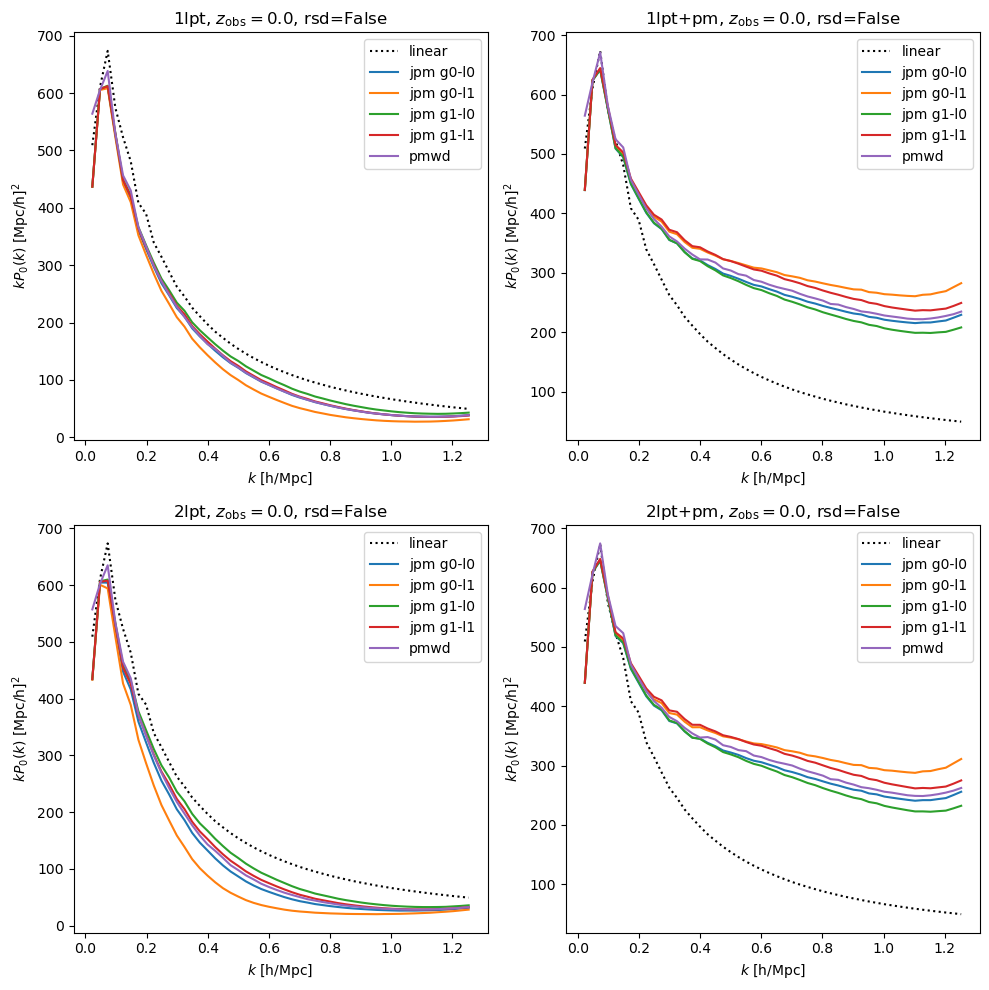

In [59]:
plot_ratio = False
i_pole = 0
multipole = multipoles[i_pole]
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(x)+jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)
relerr = lambda x, y: jnp.abs(x)/jnp.abs(y)
cmap = plt.get_cmap('Dark2')
cmap = plt.get_cmap('tab10')
pm_str = ["1lpt","1lpt+pm","2lpt","2lpt+pm"]

# theme_switch(usetex=True, font_size=12)
plt.figure(figsize=(10,10))
for i_pm in range(4):
    plt.subplot(2, 2, i_pm+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    # plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[i_pole+1], *args, **kwargs)
    # plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.plot(pk1[0], pk1[0]*relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)
    plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.semilogy(pk1[0], relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)

    if plot_ratio:
        plt.hlines(1, 0, pk_pmwd[i_pm, 0].max(), 'k')
        plot_fn(pk_jpm[0, i_pm], pk_pmwd[i_pm], c=cmap(0), label=f"jpm g{0}-l{0}")    
        plot_fn(pk_jpm[1, i_pm], pk_pmwd[i_pm], c=cmap(1), label=f"jpm g{0}-l{1}")
        plot_fn(pk_jpm[2, i_pm], pk_pmwd[i_pm], c=cmap(2), label=f"jpm g{1}-l{0}")    
        plot_fn(pk_jpm[3, i_pm], pk_pmwd[i_pm], c=cmap(3), label=f"jpm g{1}-l{1}")
        plt.legend()
        plt.ylabel(f"$\\hat P_{multipole}/P_{multipole}(k)$")
    else:
        if multipole == 0:
            plot_fn(pk_lin_obs, ':k', label=f"linear")

        # for i in range(4):
        #     plot_fn(pk_jpm[i], cmap(i), label=f"g{i//2}-l{i%2}")
        plot_fn(pk_jpm[0, i_pm], c=cmap(0), label=f"jpm g{0}-l{0}")    
        plot_fn(pk_jpm[1, i_pm], c=cmap(1), label=f"jpm g{0}-l{1}")
        plot_fn(pk_jpm[2, i_pm], c=cmap(2), label=f"jpm g{1}-l{0}")    
        plot_fn(pk_jpm[3, i_pm], c=cmap(3), label=f"jpm g{1}-l{1}")
      
        plot_fn(pk_pmwd[i_pm], c=cmap(4), label=f"pmwd")
        # plot_fn(pk_fpm*np.array([1,75,1,1])[:,None], '-+', c=cmap(5), label=f"fpm")

        plt.ylabel(f"$k P_{multipole}(k)$ [Mpc/h]$^2$")  
    plt.legend(loc='upper right')

    plt.xlabel("$k$ [h/Mpc]"),
    # plt.title(pm_str[i_pm]+", $z_{\\textrm{obs}}="+f"{1/a_obs-1:.1f}$, rsd={rsd}")
    plt.title(pm_str[i_pm]+", $z_{\\text{obs}}="+f"{1/a_obs-1:.1f}$, rsd={rsd}")
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"pkl_gradlap_a{a_lpt:.2f}-{a_obs:.2f}_mesh{mesh_length:d}_bos{box_length}_rsd{rsd:b}_ratio{plot_ratio:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

/feynman/work/dphp/hs276503/envs/montenvtest2/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


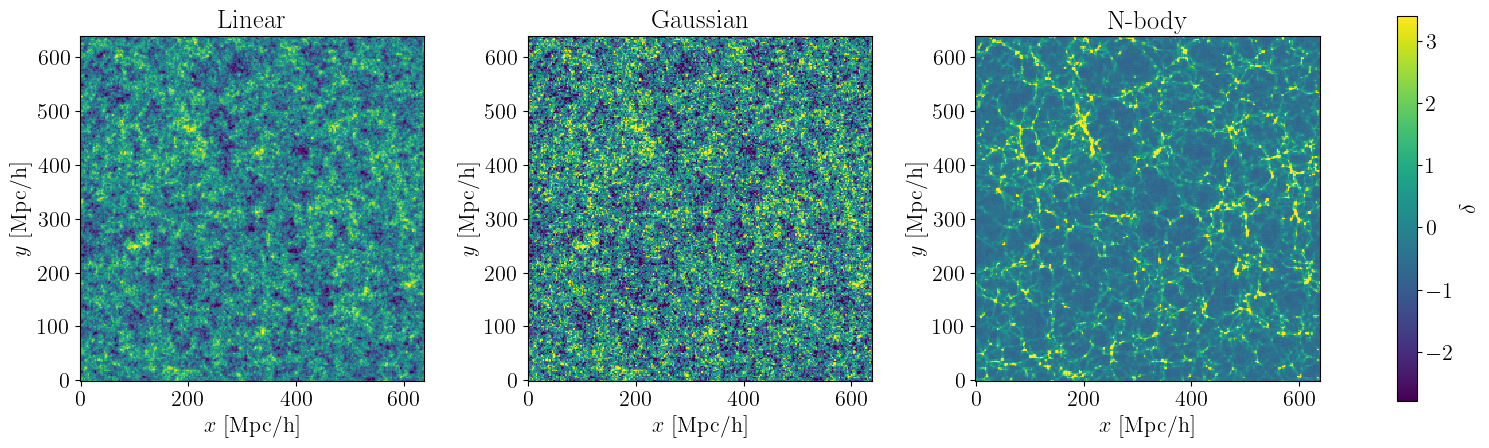

In [4]:
k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmology, k, a=a_obs)
pk_interp = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
mesh_lin = linear_field(mesh_shape, box_shape, pk_interp, seed=jr.key(0))
pk_lin = pk_fn(mesh_lin)

pk_fn2 = lambda x: jnp.abs(jc.scipy.interpolate.interp(x.reshape([-1]), pk_jpm2[0], pk_jpm2[1]).reshape(x.shape))
mesh_gauss = linear_field(mesh_shape, box_shape, pk_fn2, seed=jr.key(0))
pk_gauss = pk_fn(mesh_gauss)
n_tomean = 13
mesh_toplot = jnp.stack([mesh_lin+1, mesh_gauss+1, res])[:,:n_tomean].mean(1)
vmin, vmax = jnp.quantile(mesh_toplot, jnp.array([0.01,0.99]))
xx, yy = np.indices(mesh_shape[:2]) * (box_shape/mesh_shape)[:2,None,None]


plt.figure(figsize=(20,5))
theme_switch(usetex=True, font_size=16)
plt.subplot(131)
plt.pcolormesh(xx, yy, mesh_toplot[0], vmin=vmin, vmax=vmax)
plt.title("Linear")
plt.gca().set_aspect(1)
plt.xlabel("$x$ [Mpc/h]"), plt.ylabel("$y$ [Mpc/h]")
plt.subplot(132)
plt.pcolormesh(xx, yy, mesh_toplot[1], vmin=vmin, vmax=vmax)
plt.title("Gaussian")
plt.gca().set_aspect(1)
plt.xlabel("$x$ [Mpc/h]"), plt.ylabel("$y$ [Mpc/h]")
plt.subplot(133)
plt.pcolormesh(xx, yy, mesh_toplot[2], vmin=vmin, vmax=vmax)
plt.title("N-body")
plt.gca().set_aspect(1)
plt.xlabel("$x$ [Mpc/h]"), plt.ylabel("$y$ [Mpc/h]")
# plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.colorbar(ax=plt.gcf().axes).set_label("$1+\\delta$")

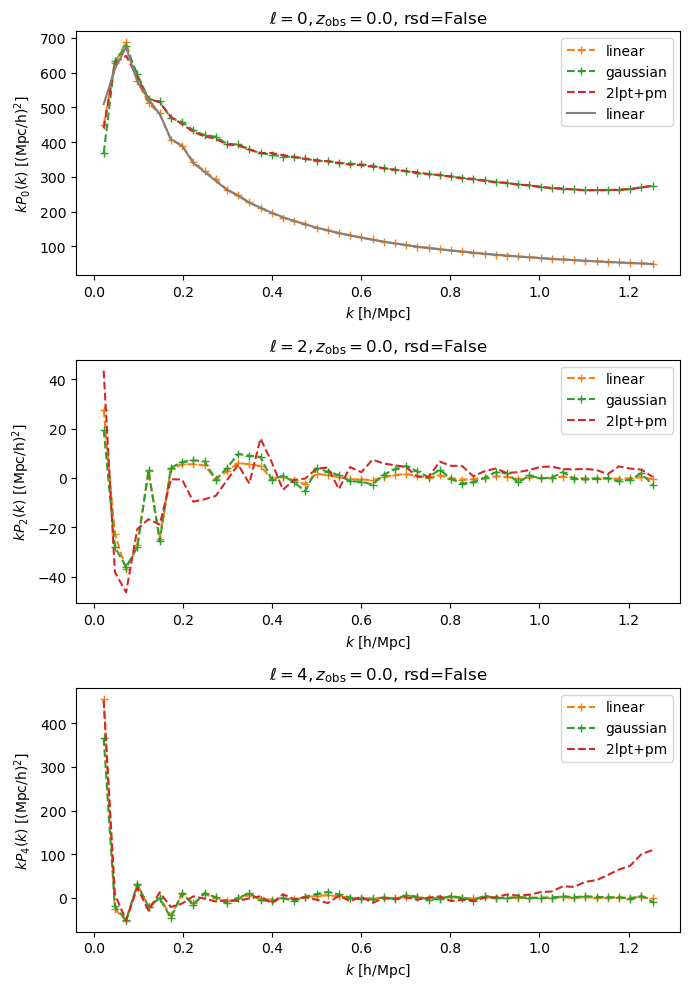

In [5]:
theme_switch()
plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    plot_fn(pk_lin, '+--C1', label=f"linear")
    plot_fn(pk_gauss, '+--C2', label=f"gaussian")
    plot_fn(pk_jpm2, '--C3', label=f"2lpt+pm")
    if multipole == 0:
        plot_fn(pk_lin_obs, 'grey', label=f"linear")
    plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")  

    plt.legend()
    plt.xlabel("$k$ [h/Mpc]"),
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/a_obs-1:.1f}$, rsd={rsd}")
plt.tight_layout()

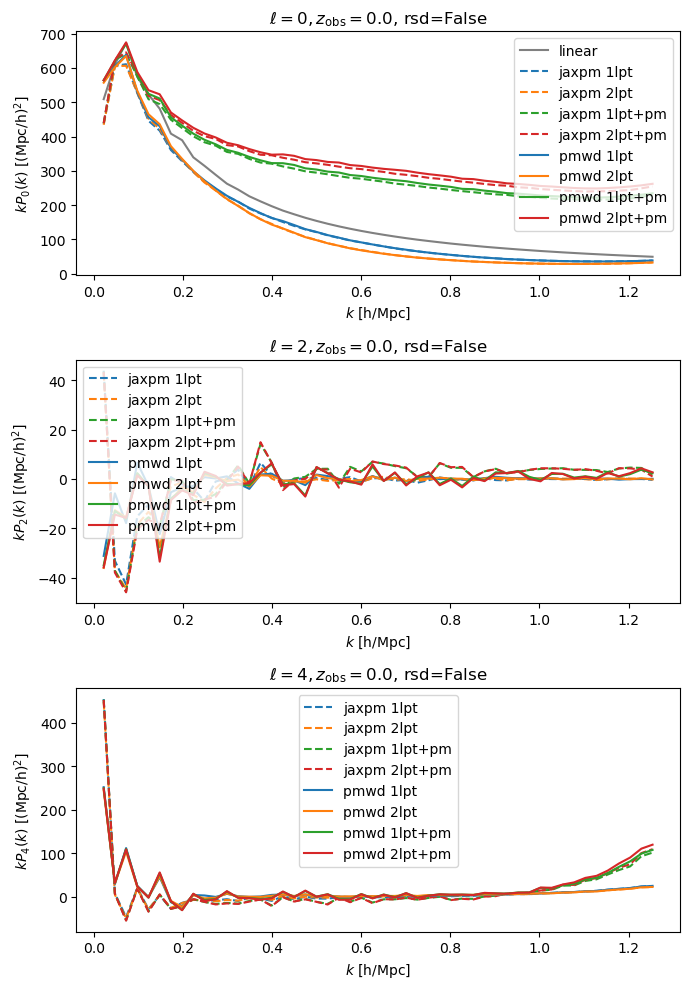

In [35]:
plot_ratio = False
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(x)+jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)
relerr = lambda x, y: jnp.abs(x)/jnp.abs(y)

plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    # plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.plot(pk1[0], pk1[0]*relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)
    plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.semilogy(pk1[0], relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)
    # plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[i_pole+1], *args, **kwargs)

    if plot_ratio:
        plt.hlines(1, 0, pk_jlpt1[0].max(), 'k')
        plot2_fn(pk_jlpt1, pk_lptwd1, 'C0', label=f"1lpt")
        plot2_fn(pk_jlpt2, pk_lptwd2, 'C1', label=f"2lpt")
        plot2_fn(pk_jpm1, pk_pmwd1, 'C2', label=f"1lpt+pm")
        plot2_fn(pk_jpm2, pk_pmwd2, 'C3', label=f"2lpt+pm")
        plt.ylabel(f"$\\hat P_{multipole}/P_{multipole}(k)$")
        # plt.ylim(1/3, 3)
    else:
        if multipole == 0:
            plot_fn(pk_lin_obs, 'grey', label=f"linear")

        plot_fn(pk_jlpt1, '--C0', label=f"jaxpm 1lpt")
        plot_fn(pk_jlpt2, '--C1', label=f"jaxpm 2lpt")
        plot_fn(pk_jpm1, '--C2', label=f"jaxpm 1lpt+pm")
        plot_fn(pk_jpm2, '--C3', label=f"jaxpm 2lpt+pm")

        plot_fn(pk_lptwd1, 'C0', label=f"pmwd 1lpt")    
        plot_fn(pk_lptwd2, 'C1', label=f"pmwd 2lpt")
        plot_fn(pk_pmwd1, 'C2', label=f"pmwd 1lpt+pm")    
        plot_fn(pk_pmwd2, 'C3', label=f"pmwd 2lpt+pm")
        plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")  

    plt.legend()
    plt.xlabel("$k$ [h/Mpc]"),
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/a_obs-1:.1f}$, rsd={rsd}")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_jaxpmwd_g{grad_order}l{grad_order}_a{a_lpt:.2f}-{a_obs:.2f}_mesh{mesh_length:d}_box{box_length:d}_rsd{rsd:b}_ratio{plot_ratio:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

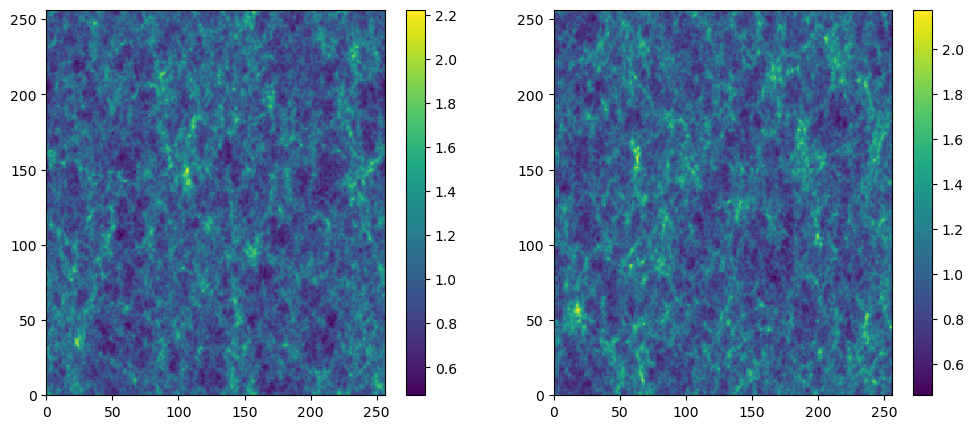

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh((res).mean(axis=0))
plt.colorbar()
plt.subplot(122)
plt.pcolormesh((res_pmwd).mean(axis=1)[::-1,::-1])
plt.colorbar()

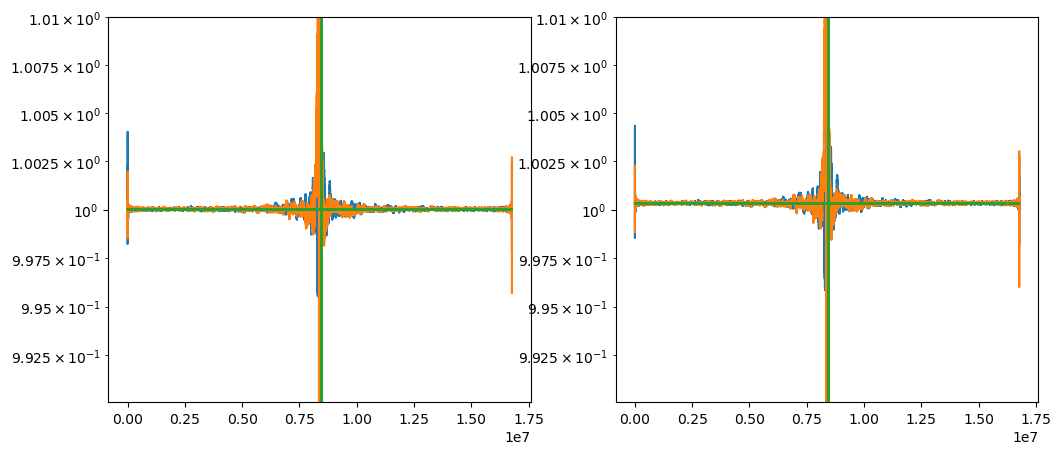

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.semilogy(jnp.abs(jnp.sort(res[0], 0)/jnp.sort(res_pmwd[0], 0)))
plt.ylim(1/1.01,1.01)
plt.subplot(122)
plt.semilogy(jnp.abs(jnp.sort(res[1], 0)/jnp.sort(res_pmwd[1], 0)))
plt.ylim(1/1.01,1.01)
plt.show();